# Practical Applications of QPE

In [1]:
from qiskit import QuantumCircuit
from qiskit.providers.basic_provider import BasicSimulator
from qiskit.visualization import plot_histogram, plot_bloch_vector, plot_bloch_multivector
from qiskit.primitives import BackendSampler
from qiskit.quantum_info import SparsePauliOp, Statevector, Pauli
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import UnitaryGate

from numpy import pi
import numpy as np
import matplotlib.pyplot as plt

from scipy.linalg import expm

from qiskit.circuit.library import QFT

In [ ]:

if __name__ == "__main__":
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["mathtext.fontset"] = "dejavuserif"

    # NOTE I usually make plots 0.5*\textwidth; this font size is legible 
    plt.rcParams.update({"font.size": 22})

    resolution = 150

    x_data = np.linspace(0, 5, num=101)
    y_data1 = x_data
    y_data2 = 2 * x_data

    fig, (ax1) = plt.subplots(1, 1, figsize=(8, 6))

    ax1.plot(x_data, y_data1, "-*", label="data 1")
    ax1.plot(x_data, y_data2, "-", label="data 2")

    # ax1.set_yscale('log')
    # ax1.set_xscale('log')
    # ax1.set_ylim([0.,2])

    ax1.legend(loc="upper center")
    ax1.set_title("Some title", pad=20)
    ax1.set_xlabel("x-label")
    ax1.set_ylabel("y-label")

    fig.tight_layout()
    fig.savefig(
        "",
        bbox_inches="tight",
        dpi=resolution,
        transparent=True,
        facecolor="w",
        edgecolor="w",
        orientation="landscape",
    )

    plt.show()

## Transverse Ising Model
One model for quantum particles is the Transverse Ising Model. This model represents particles with spin either aligned or anti-algined with the Z access (the first term) with an external electromagnetic field (the second term). Finding the ground state of this system is the same as finding what will happen in reality when particles are setup in this fashion.

The Hamiltonian from the Transverse Ising Model is defined as
$$ H = -\sum_{i=0}^{n-1} Z_iZ_{i+1} - g\sum_{i=0}^nX_i $$
where $n$ is the number of particles.

To simulate a Hamiltonian on a quantum computer some preprocessing is normally required. The schordinger equation states that:

$$ i \hbar \frac{\partial}{\partial t} |\psi \rangle = H |\psi \rangle $$

Solving the differential equation for $|\psi \rangle$ gives the following equation:

$$ |\psi \rangle = e^{itH}|\psi_0 \rangle $$

Suppose now that the Hamiltonian is a combination of different Hamiltonians.

$$ H = H_1 + H_2 $$

Since we are exponetiting matrices it is not nessarily the case that $e^{H} = e^{H_1}e^{H_2}$ instead the Lie Product formula must be used. When applied to the Hamiltonian given

$$ e^{itH} = \lim_{L \to \infty }\left(e^{itH_1/L}e^{itH_2/L}\right)^L$$

Suppose now we wanted to approximate the value of $e^{itH}$ using a finite $L$ and wanted to determine the error of such approximation. The complexity of the error in the trotter is equivent to the logarithm of constants in the exponential.

$$ e^{itH_1/L}e^{itH_2/L} = \mathcal{O}(t^2/L^2)$$

Therefore the total error of the calculation must be on the order of $\mathcal{O}( (t^2/L^2) \times L) = \mathcal{O}(t^2/L)$ which means that if we want percision $\epsilon$ we need $L = \mathcal{O}(t^2/\epsilon)$, which is not zero.

Specifically for the Transverse Ising Model, for the simulation to be 100% accurate, it is required that the matrices commute, or that $AB = BA$. If the matrices commute that means the standard rule for expontiation can be applied and the matrix can be simulated without error. Luckily Since the both parts of the Hamiltonian for the Transverse Ising Model are expressed as a summation of Pauli operators, the terms in those summations will commute, allowing us to use the standard rule for exponentiation without any error. 

## Ansatz

QPE can determine the phase of any statevector. When using QPE to measure the ground state, the inital guess must be a superposition of the basis of eigenvectors of the matrix. That space is not nessarily given nor trivially computable. Standardly, a guess for the state is made instead. This initial guess or ansatz greatly affects the output when using QPE. With a bad ansatz when the computation is done, many different energy values are excluded, possiblily leading to an incorrect ground state. One proposed method is called Variational Quantum Eigensolver (VQE), which runs QPE then tweaks the ansatz to reduce the outputted ground state until it approaches the correct value. 

## Computation

With small values of g the first term of the Hamiltonian dominates the expression meaning the eigenvectors of the Hamiltonian will not have a lot of superposition of the possible spin states.

In [12]:
eigen_bits = 4
g = 0
ancilla_bits = 4

In [13]:
H = np.zeros((2**eigen_bits, 2**eigen_bits), dtype=np.complex128)

# construct the Hamiltonian
# with Pauli Operators in Qiskit ^ represents a tensor product
print("H = ", end='')
for i in range(eigen_bits-1):
    temp = Pauli('')
    for j in range(eigen_bits):
        if (j == i or j == i+1):
            temp ^= Pauli('Z')
        else:
            temp ^= Pauli('I')
    print("-"+str(temp)+" ", end='')
    H += -temp.to_matrix()
print("\n")

# normalize the Hamiltonian
H = (np.pi/16)*H/np.linalg.norm(H, ord=2)

# rotate matrix so that it will be positive definite
H += 2*pi/16*np.eye(2**eigen_bits)

print("Eigenvalues of the Hamiltonian:\n", np.linalg.eigvals(H))
min_eigenvalue = np.min(np.linalg.eigvals(H))
print("\nLowest energy Eigenvalue", min_eigenvalue)



# convert revolutions to radians
H *= 2*np.pi*1j

# convert the rotations to complex numbers
H = expm(H)

# print("Hamiltonian for Ising Model:\n",H)

# def is_unitary_matrix(matrix):
#     return np.allclose(np.eye(matrix.shape[0]), matrix @ matrix.conj().T)
# print(is_unitary_matrix(H))

H = -ZZII -IZZI -IIZZ 

Eigenvalues of the Hamiltonian:
 [0.19634954+0.j 0.32724923+0.j 0.45814893+0.j 0.32724923+0.j
 0.45814893+0.j 0.58904862+0.j 0.45814893+0.j 0.32724923+0.j
 0.32724923+0.j 0.45814893+0.j 0.58904862+0.j 0.45814893+0.j
 0.32724923+0.j 0.45814893+0.j 0.32724923+0.j 0.19634954+0.j]

Lowest energy Eigenvalue (0.19634954084936207+0j)


ANSATZ:


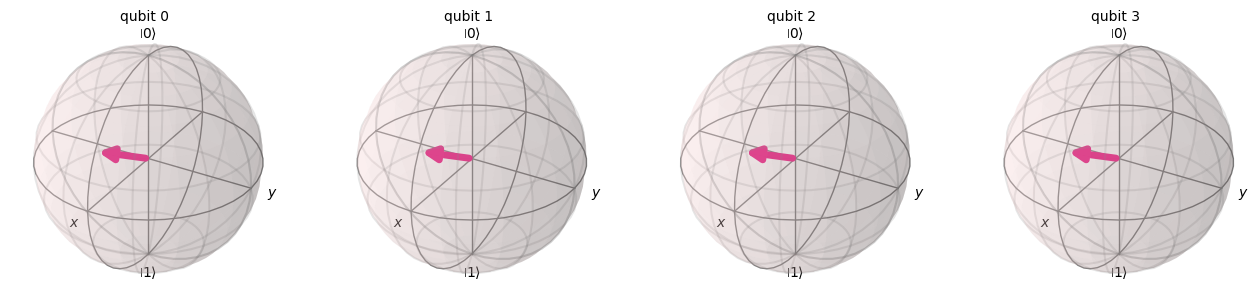

In [26]:
qr_eigenstate = QuantumRegister(eigen_bits)
qc = QuantumCircuit(qr_eigenstate)

# prepare state
qc.ry(pi/3,qr_eigenstate)
sv = Statevector(qc)
print("ANSATZ:")
plot_bloch_multivector(sv)

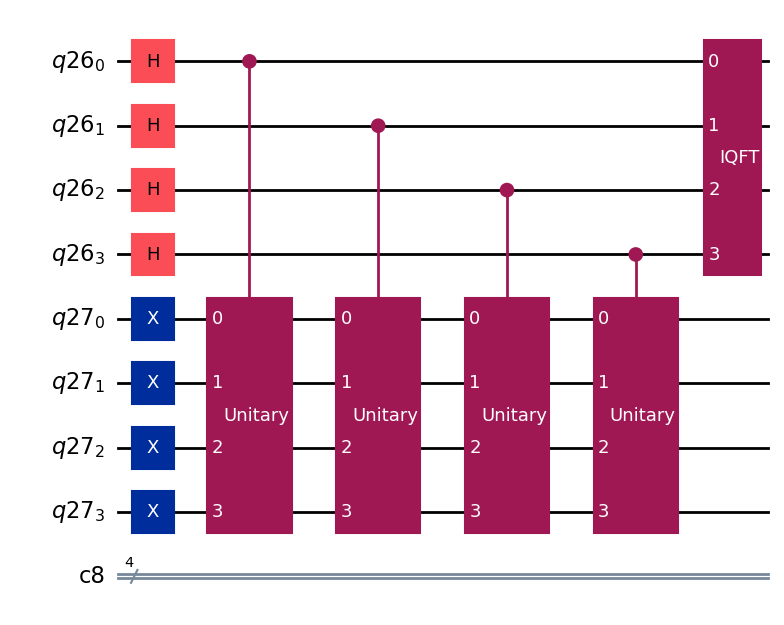

In [35]:
qr_ancilla = QuantumRegister(ancilla_bits)
qr_eigenstate = QuantumRegister(eigen_bits)
cr = ClassicalRegister(ancilla_bits)
qc = QuantumCircuit(qr_ancilla, qr_eigenstate, cr)

# prepare state
qc.h(qr_ancilla)
qc.x(qr_eigenstate)

for i in range(ancilla_bits):
    mat = np.linalg.matrix_power(H, 2**(i))
    controlled_U = UnitaryGate(mat).control(annotated="yes")
    qc.append(controlled_U, qargs = [qr_ancilla[i]] + qr_eigenstate[:] )

# for i in range(int(ancilla_bits/2)):
#     qc.swap(i, ancilla_bits-i-1)

qc.append(QFT(ancilla_bits).inverse(), qr_ancilla)
# measure(qc, ancilla_bits)
qc.draw('mpl')

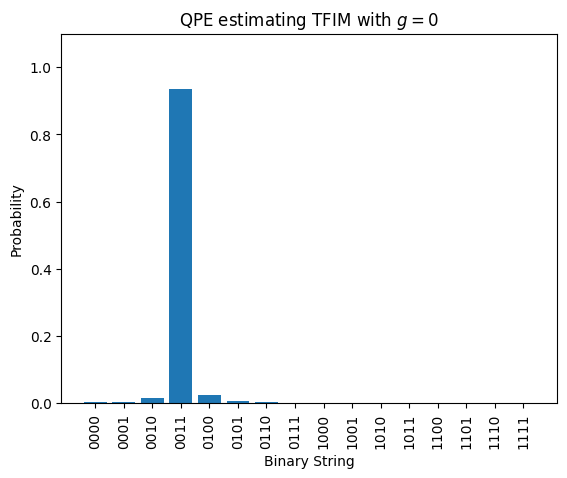

In [36]:
ideal_distribution = Statevector.from_instruction(qc).probabilities_dict()
new_dist = {}
for key in ideal_distribution:
    try:
        new_dist[key[eigen_bits:]] += ideal_distribution[key]
    except:
        new_dist[key[eigen_bits:]] = ideal_distribution[key]

fig,ax = plt.subplots()
plt.xticks(rotation=90)
plt.ylabel("Probability")
plt.xlabel("Binary String")
plt.title("QPE estimating TFIM with $g=0$")
bar = ax.bar(new_dist.keys(), new_dist.values())
# ax.bar_label(bar, fmt=lambda x: f' {x:.3f}', rotation=90)
ax.set_ylim(ymax = 1.1)
plt.show()

In [37]:
max_num = 0
binary_num = ''
for key in ideal_distribution:
    if (ideal_distribution[key] > max_num):
        max_num = ideal_distribution[key]
        binary_num = key
        
binary_num = binary_num[eigen_bits:]
decimal_num = int(binary_num, 2) / (2 ** (ancilla_bits))

print("Lowest energy Eigenvalue", min_eigenvalue.real)
print("Binary Number Output: 0."+str(binary_num))
print("Decimal Number with Equivalent Value:",decimal_num)

Lowest energy Eigenvalue 0.19634954084936207
Binary Number Output: 0.0011
Decimal Number with Equivalent Value: 0.1875


Similary with large values of g the first term of the Hamiltonian dominates the expression meaning the eigenvectors of the Hamiltonian will not have a lot of superposition of the possible spin states.

In [204]:
eigen_bits = 4
g = 10**8
ancilla_bits = 4

In [205]:
H = np.zeros((2**eigen_bits, 2**eigen_bits), dtype=np.complex128)

# construct the Hamiltonian
# with Pauli Operators in Qiskit ^ represents a tensor product
print("H = ", end='')
for i in range(eigen_bits):
    temp = Pauli('')
    for j in range(eigen_bits):
        if (j == i):
            temp ^= Pauli('X')
        else:
            temp ^= Pauli('I')
    print("-g"+str(temp)+" ", end='')
    H += -g*temp.to_matrix()
print("\n")

# normalize the Hamiltonian
H = (np.pi/16)*H/np.linalg.norm(H, ord=2)

# rotate matrix so that it will be positive definite
H += 2*pi/16*np.eye(2**eigen_bits)

print("Eigenvalues of the Hamiltonian:\n", np.linalg.eigvals(H))
min_eigenvalue = np.min(np.linalg.eigvals(H))
print("\nLowest energy Eigenvalue", min_eigenvalue)



# convert revolutions to radians
H *= 2*np.pi*1j

# convert the rotations to complex numbers
H = expm(H)

# print("Hamiltonian for Ising Model:\n",H)

# def is_unitary_matrix(matrix):
#     return np.allclose(np.eye(matrix.shape[0]), matrix @ matrix.conj().T)
# print(is_unitary_matrix(H))

H = -gXIII -gIXII -gIIXI -gIIIX 

Eigenvalues of the Hamiltonian:
 [0.58904862+0.j 0.19634954+0.j 0.39269908+0.j 0.29452431+0.j
 0.49087385+0.j 0.49087385+0.j 0.39269908+0.j 0.29452431+0.j
 0.29452431+0.j 0.39269908+0.j 0.49087385+0.j 0.29452431+0.j
 0.39269908+0.j 0.49087385+0.j 0.39269908+0.j 0.39269908+0.j]

Lowest energy Eigenvalue (0.1963495408493623+0j)


ANSATZ:


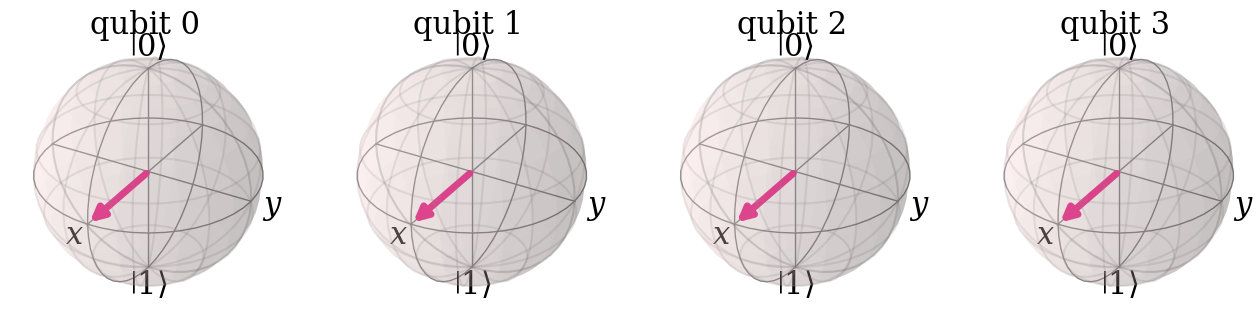

In [206]:
qr_eigenstate = QuantumRegister(eigen_bits)
qc = QuantumCircuit(qr_eigenstate)

# prepare state
qc.h(qr_eigenstate)

sv = Statevector(qc)
print("ANSATZ:")
plot_bloch_multivector(sv)

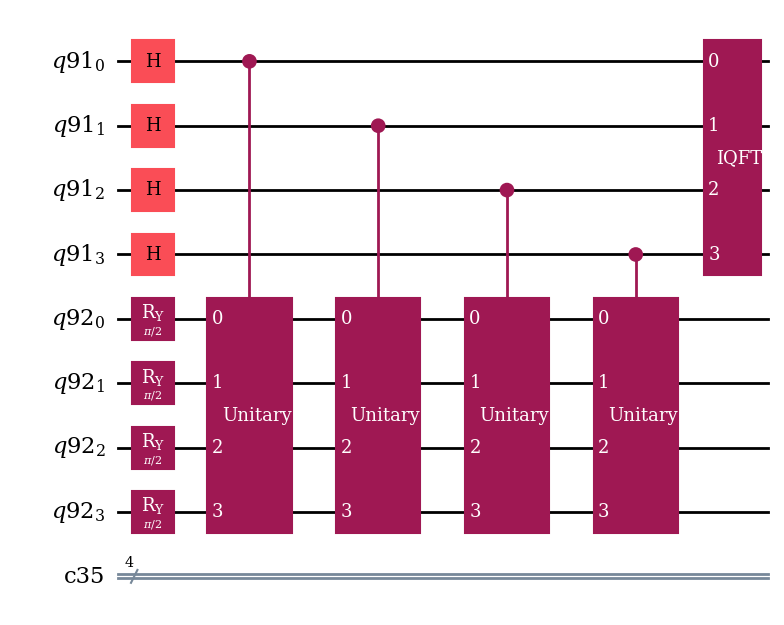

In [207]:
qr_ancilla = QuantumRegister(ancilla_bits)
qr_eigenstate = QuantumRegister(eigen_bits)
cr = ClassicalRegister(ancilla_bits)
qc = QuantumCircuit(qr_ancilla, qr_eigenstate, cr)

# prepare state
qc.h(qr_ancilla)
qc.ry(pi/2, qr_eigenstate)

for i in range(ancilla_bits):
    mat = np.linalg.matrix_power(H, 2**(i))
    controlled_U = UnitaryGate(mat).control(annotated="yes")
    qc.append(controlled_U, qargs = [qr_ancilla[i]] + qr_eigenstate[:] )

# for i in range(int(ancilla_bits/2)):
#     qc.swap(i, ancilla_bits-i-1)

qc.append(QFT(ancilla_bits).inverse(), qr_ancilla)
# measure(qc, ancilla_bits)
qc.draw('mpl')

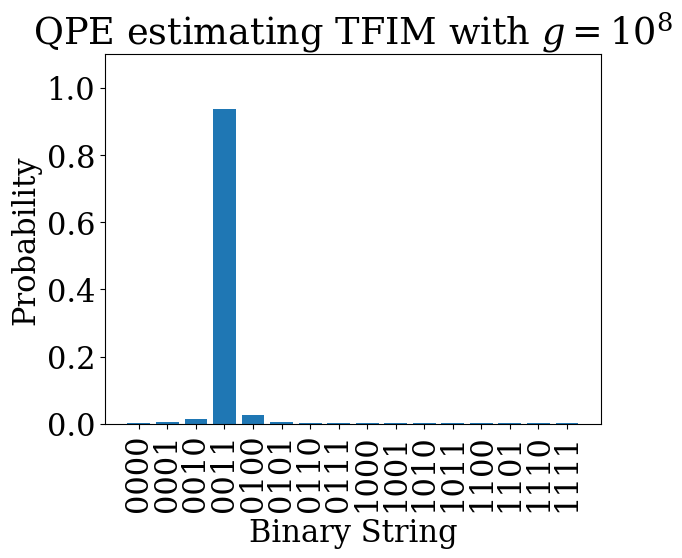

In [211]:
ideal_distribution = Statevector.from_instruction(qc).probabilities_dict()
new_dist = {}
for key in ideal_distribution:
    try:
        new_dist[key[eigen_bits:]] += ideal_distribution[key]
    except:
        new_dist[key[eigen_bits:]] = ideal_distribution[key]

fig,ax = plt.subplots()
plt.xticks(rotation=90)
plt.ylabel("Probability")
plt.xlabel("Binary String")
plt.title("QPE estimating TFIM with $g=10^8$")
bar = ax.bar(new_dist.keys(), new_dist.values())
# ax.bar_label(bar, fmt=lambda x: f' {x:.3f}', rotation=90)
ax.set_ylim(ymax = 1.1)
plt.show()

In [212]:
max_num = 0
binary_num = ''
for key in ideal_distribution:
    if (ideal_distribution[key] > max_num):
        max_num = ideal_distribution[key]
        binary_num = key
        
binary_num = binary_num[eigen_bits:]
decimal_num = int(binary_num, 2) / (2 ** (ancilla_bits))

print("Lowest energy Eigenvalue", min_eigenvalue.real)
print("Binary Number Output: 0."+str(binary_num))
print("Decimal Number with Equivalent Value:",decimal_num)

Lowest energy Eigenvalue 0.1963495408493623
Binary Number Output: 0.0011
Decimal Number with Equivalent Value: 0.1875


In between high and low energy values the ansatz is ambiguous since the superposition in the eigenvectors is not negligible. But luckily since at both high and low g values the statevector is just superposition of $|0\rangle$ and $|1\rangle$, it is likely the case that intermediate values of g will still have eigenvectors that are in that same superposition.

In [213]:
eigen_bits = 4
g = 1
ancilla_bits = 4

In [214]:
H = np.zeros((2**eigen_bits, 2**eigen_bits), dtype=np.complex128)

# construct the Hamiltonian
# with Pauli Operators in Qiskit ^ represents a tensor product
print("H = ", end='')
for i in range(eigen_bits-1):
    temp = Pauli('')
    for j in range(eigen_bits):
        if (j == i or j == i+1):
            temp ^= Pauli('Z')
        else:
            temp ^= Pauli('I')
    print("-"+str(temp)+" ", end='')
    H += -temp.to_matrix()
for i in range(eigen_bits):
    temp = Pauli('')
    for j in range(eigen_bits):
        if (j == i):
            temp ^= Pauli('X')
        else:
            temp ^= Pauli('I')
    print("-g"+str(temp)+" ", end='')
    H += -g*temp.to_matrix()
print("\n")

# normalize the Hamiltonian
H = (np.pi/16)*H/np.linalg.norm(H, ord=2)

# rotate matrix so that it will be positive definite
H += 2*pi/16*np.eye(2**eigen_bits)

print("Eigenvalues of the Hamiltonian:\n", np.linalg.eigvals(H))
min_eigenvalue = np.min(np.linalg.eigvals(H))
print("\nLowest energy Eigenvalue", min_eigenvalue)



# convert revolutions to radians
H *= 2*np.pi*1j

# convert the rotations to complex numbers
H = expm(H)

# print("Hamiltonian for Ising Model:\n",H)

# def is_unitary_matrix(matrix):
#     return np.allclose(np.eye(matrix.shape[0]), matrix @ matrix.conj().T)
# print(is_unitary_matrix(H))

H = -ZZII -IZZI -IIZZ -gXIII -gIXII -gIIXI -gIIIX 

Eigenvalues of the Hamiltonian:
 [0.19634954+0.j 0.22500883+0.j 0.58904862+0.j 0.30752995+0.j
 0.32277924+0.j 0.5065275 +0.j 0.47786822+0.j 0.38009781+0.j
 0.40530036+0.j 0.56038934+0.j 0.27887066+0.j 0.35143852+0.j
 0.43395964+0.j 0.46261893+0.j 0.43395964+0.j 0.35143852+0.j]

Lowest energy Eigenvalue (0.19634954084936157+0j)


ANSATZ:


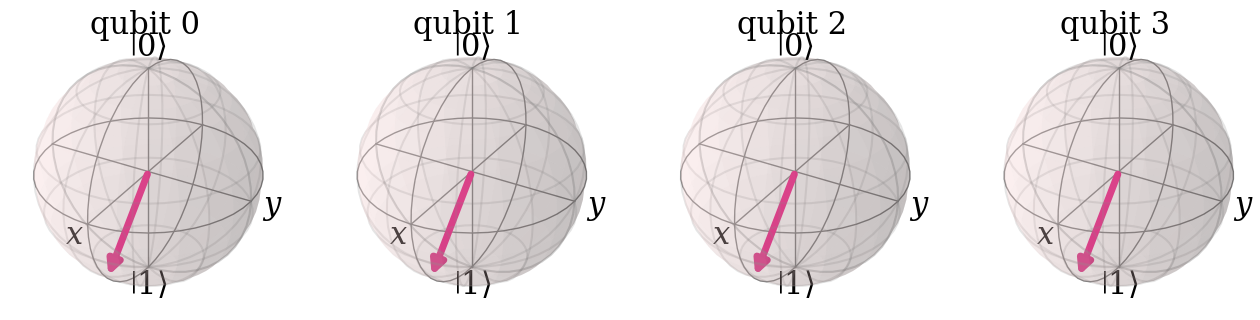

In [215]:
qr_eigenstate = QuantumRegister(eigen_bits)
qc = QuantumCircuit(qr_eigenstate)

# prepare state
qc.ry(3*pi/4, qr_eigenstate)
sv = Statevector(qc)
print("ANSATZ:")
plot_bloch_multivector(sv)

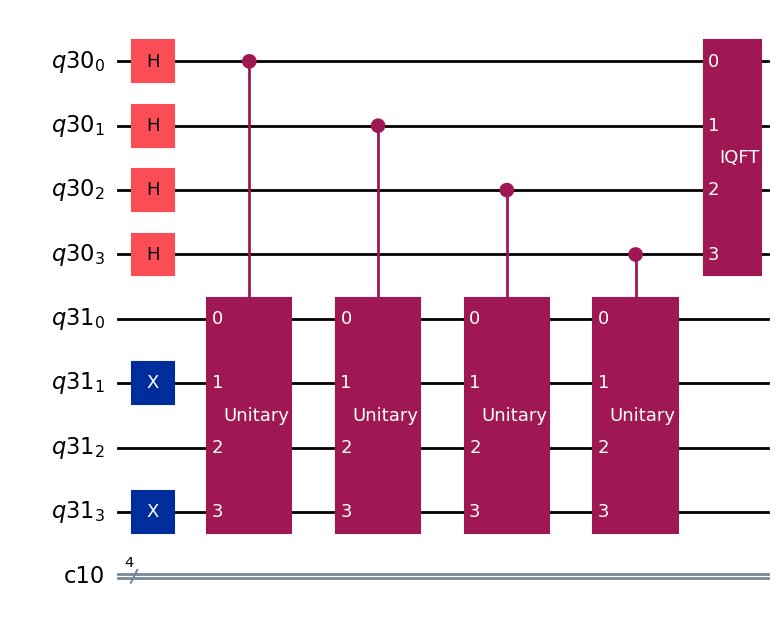

In [41]:
qr_ancilla = QuantumRegister(ancilla_bits)
qr_eigenstate = QuantumRegister(eigen_bits)
cr = ClassicalRegister(ancilla_bits)
qc = QuantumCircuit(qr_ancilla, qr_eigenstate, cr)

# prepare state
qc.h(qr_ancilla)
qc.ry(3/4*pi, qr_eigenstate)

for i in range(ancilla_bits):
    mat = np.linalg.matrix_power(H, 2**(i))
    controlled_U = UnitaryGate(mat).control(annotated="yes")
    qc.append(controlled_U, qargs = [qr_ancilla[i]] + qr_eigenstate[:] )

# for i in range(int(ancilla_bits/2)):
#     qc.swap(i, ancilla_bits-i-1)

qc.append(QFT(ancilla_bits).inverse(), qr_ancilla)
# measure(qc, ancilla_bits)
qc.draw('mpl')

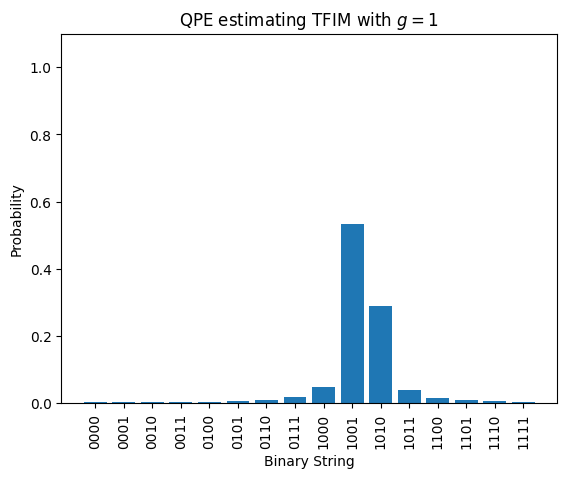

In [42]:
ideal_distribution = Statevector.from_instruction(qc).probabilities_dict()
new_dist = {}
for key in ideal_distribution:
    try:
        new_dist[key[eigen_bits:]] += ideal_distribution[key]
    except:
        new_dist[key[eigen_bits:]] = ideal_distribution[key]

fig,ax = plt.subplots()
plt.xticks(rotation=90)
plt.ylabel("Probability")
plt.xlabel("Binary String")
plt.title("QPE estimating TFIM with $g=1$")
bar = ax.bar(new_dist.keys(), new_dist.values())
# ax.bar_label(bar, fmt=lambda x: f' {x:.3f}', rotation=90)
ax.set_ylim(ymax = 1.1)
plt.show()

In [40]:
max_num = 0
binary_num = ''
for key in new_dist:
    if (new_dist[key] > max_num):
        max_num = new_dist[key]
        binary_num = key
decimal_num = int(binary_num, 2) / (2 ** (ancilla_bits))

print("Lowest energy Eigenvalue", min_eigenvalue.real)
print("Binary Number Output: 0."+str(binary_num))
print("Decimal Number with Equivalent Value:",decimal_num)

Lowest energy Eigenvalue 0.19634954084936207
Binary Number Output: 0.1001
Decimal Number with Equivalent Value: 0.5625


## Testing a bunch of different ansatz

In [166]:
eigen_bits = 4
g = 1
ancilla_bits = 6

In [167]:
H = np.zeros((2**eigen_bits, 2**eigen_bits), dtype=np.complex128)

print("H = ", end='')
for i in range(eigen_bits-1):
    temp = Pauli('')
    for j in range(eigen_bits):
        if (j == i or j == i+1):
            temp ^= Pauli('Z')
        else:
            temp ^= Pauli('I')
    print("-"+str(temp)+" ", end='')
    H += -temp.to_matrix()
print("\n")

# normalize the Hamiltonian
H = (np.pi/16)*H/np.linalg.norm(H, ord=2)

# rotate matrix so that it will be positive definite
H += 2*pi/16*np.eye(2**eigen_bits)

print("Eigenvalues of the Hamiltonian:\n", np.linalg.eigvals(H))
min_eigenvalue = np.min(np.linalg.eigvals(H))
print("\nLowest energy Eigenvalue", min_eigenvalue)

# convert revolutions to radians
H *= 2*np.pi*1j

# convert the rotations to complex numbers
H = expm(H)

H = -ZZII -IZZI -IIZZ 

Eigenvalues of the Hamiltonian:
 [0.19634954+0.j 0.32724923+0.j 0.45814893+0.j 0.32724923+0.j
 0.45814893+0.j 0.58904862+0.j 0.45814893+0.j 0.32724923+0.j
 0.32724923+0.j 0.45814893+0.j 0.58904862+0.j 0.45814893+0.j
 0.32724923+0.j 0.45814893+0.j 0.32724923+0.j 0.19634954+0.j]

Lowest energy Eigenvalue (0.19634954084936207+0j)


In [168]:
angles = np.linspace(0,2*pi,50)

In [169]:
qr_ancilla = QuantumRegister(ancilla_bits)
qr_eigenstate = QuantumRegister(eigen_bits)
cr = ClassicalRegister(ancilla_bits)
qc = QuantumCircuit(qr_ancilla, qr_eigenstate, cr)

lowest_energy = []
for angle in angles:
    
    # prepare state
    qc.h(qr_ancilla)
    qc.ry(angle, qr_eigenstate)
    
    for i in range(ancilla_bits):
        mat = np.linalg.matrix_power(H, 2**(i))
        controlled_U = UnitaryGate(mat).control(annotated="yes")
        qc.append(controlled_U, qargs = [qr_ancilla[i]] + qr_eigenstate[:] )
        
    qc.append(QFT(ancilla_bits).inverse(), qr_ancilla)
    qc.draw('mpl')
    ideal_distribution = Statevector.from_instruction(qc).probabilities_dict()
    new_dist = {}
    for key in ideal_distribution:
        new_dist[key[eigen_bits:]] = ideal_distribution[key]

    max_num = 0
    binary_num = ''
    for key in new_dist:
        if (new_dist[key] > max_num):
            max_num = new_dist[key]
            binary_num = key
    # print(binary_num, int(binary_num, 2) / (2 ** (ancilla_bits)))
    lowest_energy.append(int(binary_num, 2) / (2 ** (ancilla_bits)))

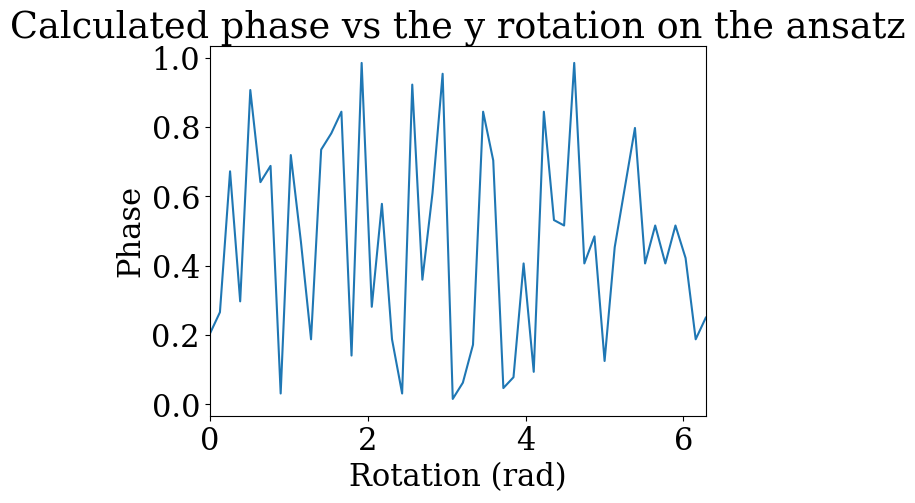

In [178]:
plt.title("Calculated phase vs the y rotation on the ansatz")
plt.plot(angles, lowest_energy)
plt.xlim([0,2*pi])
plt.xlabel("Rotation (rad)")
plt.ylabel("Phase")
plt.show()

## Making a Function (This doesn't work)

In [179]:
def rot_funct(g):
    w = pi/2*g+pi
    arctan = (np.exp(w)-np.exp(-w))/(np.exp(w)+np.exp(-w))
    ans = -pi/4*arctan+3*pi/4
    return ans

In [180]:
eigen_bits = 4
g = 10000
ancilla_bits = 6
print(rot_funct(g))

nan


C:\Users\paulb\AppData\Local\Temp\ipykernel_26060\207161337.py:3: RuntimeWarning: overflow encountered in exp
  arctan = (np.exp(w)-np.exp(-w))/(np.exp(w)+np.exp(-w))
C:\Users\paulb\AppData\Local\Temp\ipykernel_26060\207161337.py:3: RuntimeWarning: invalid value encountered in scalar divide
  arctan = (np.exp(w)-np.exp(-w))/(np.exp(w)+np.exp(-w))


In [ ]:
qr_eigenstate = QuantumRegister(eigen_bits)
qc = QuantumCircuit(qr_eigenstate)

# prepare state
qc.ry(rot_funct(g), qr_eigenstate)
# qc.h(qr_eigenstate)
sv = Statevector(qc)
print("ANSATZ:")
plot_bloch_multivector(sv)